# Raven Healthcare

### Problem Statement

The raw data has been provided to the team of Data Analysts of Raven Healthcare for preprocessing.

# COVID-19 Data

### Data Dictionary

- __agebracket__:This provides the age of the case. This is applicable only for rows that represent individual records.
- __backupnotes__:This was used during initial days to record additional information. The usage of this has been discontinued.
- __contractedfromwhichpatientsuspected__: This field gives the patient id from whom the current patient is believed to have contracted the virus. This is based on state bulletins. As of July 10th, this field is used only for Karnataka records.
- __currentstatus__:This can have: Hospitalized, Recovered, Deceased or Migrated_Others as values. These represent the status of the case. Migrated_Others is used as a place holder for those cases that are marked by states as having migrated to other states or have died due to non covid reasons.
- __dateannounced__: This field gives the date on which the case(s) was reported by the state/central bulletin
- __detectedcity__: This field gives the city where the case(s) were reported.
- __detecteddistrict__: This field gives the district where the case(s) were reported.
- __detectedstate__: This field gives the state where the case(s) were reported.
- __estimatedonsetdate__: This field is not used.gender This provides the gender of the case. This is applicable only for rows that represent individual records.
- __nationality__: This provides the nationality of the case. This is applicable only for rows that represent individual records.
- __notes__: This provides the any notes regarding the case(s) that are reported.
- __numcases__: This field can any integer value. This field denotes the following:
    - If the value is == 1 : The row indicates an individual record (age and gender info are subject to state bulletin releases).
    - If the value != 1 (greater than or less than 1) : The row indicates a district level record.
    - If the value > 0 and (detecteddistrict == '' or detecteddistrict == 'Unknown') : The row added without district details as state bulletin did not have district details at the point of data entry.
    - If the value < 0 and (detecteddistrict == '' or detecteddistrict == 'Unknown') : The row added to adjust a previously added bulk entry as stated above
    - If the value < 0 and (detecteddistrict != '' and detecteddistrict != 'Unknown') : The row added due to state bulletins providing a reduced count for that district/day/category combination.
    - If the value == 0 : Ingore the record. This would've been an entry made and ignored later due to clarifications from state bulletins.
- __patientnumber__:This field used to hold a global patient number for all patients being reported. This has been discontinued with the shift to district level entries.
- __source1__:Source for the current row.
- __source2__:Additional source for the current row.
- __source3__:Additional source for the current row.
- __statecode__:A two letter code to represent the state/UT.
- __statepatientnumber__:A field to represent the state patient number if the state bulletin provided a state patient number.
- __statuschangedate__:A field to represent the change of status of patients from Hospitalized -> Recovered or Hospitalized -> Deceased. This field has been discontiuned with district level records.

The data is collected from data.gov.in and is available in different files. The first task is to merge all the data into a single file. 

### Importing Libraries

In [2]:
import os
import os.path
import sys
import pandas as pd
import numpy as np

## Data Acquisition

### Fetching Data

We have to acquire the latest data possible. So, we will be using BeautifulSoup for this:

In [2]:
# Please wait while the library is installed
!pip install tqdm --quiet --disable-pip-version-check

In [3]:
import re
import requests as rq
from bs4 import BeautifulSoup
from tqdm import tqdm

In [4]:
# Sending request to the website
res=rq.get('https://api.covid19india.org/documentation/csv/')

In [5]:
# Creating the soup object
soup=BeautifulSoup(res.content) 

In [6]:
# finding all the hyperlinks in the page
links=soup.find_all('a')

In [7]:
# Filtering the hyperlinks with only raw_data
final=[]
for i in links:
    temp=re.search('raw_data[\d*]+.\w+',i.text)
    if temp!=None:
        final.append(i)

In [8]:
# Check if raw_data folder exists or not. If not create a new folder
current_directory=os.getcwd() # Current working directory
if os.path.exists(current_directory+'/raw_data')==False:
    os.mkdir(current_directory+'/raw_data')

In [9]:
file_path=current_directory+'\\raw_data\\'

In [10]:
#### Fetching the raw data files (This take a while if you don't have any files downloaded already)
for i in final:
    res = rq.get(i.text, stream=True)
    res.raise_for_status()
    filename=i.text.split('latest/')[1]
    file_existence = os.path.isfile(file_path+'/'+filename)

    if file_existence!=True: # file does not exists
        with open(file_path+filename, 'wb+') as fd:
            with tqdm(
                unit='B', unit_scale=True,
                desc=str(res.status_code)+' | '+filename, total=int(res.headers.get('content-length', 0))
            ) as pbar:
                for chunk in res.iter_content(chunk_size=4096):
                    fd.write(chunk)
                    pbar.update(len(chunk))
    else:
        sys.stderr.write('File already exists: '+filename+'\n')

200 | raw_data1.csv: 2.88MB [00:00, 48.9MB/s]                                                                          
200 | raw_data2.csv: 1.58MB [00:00, 7.47MB/s]                                                                          
200 | raw_data3.csv: 1.56MB [00:00, 13.7MB/s]                                                                          
200 | raw_data4.csv: 2.86MB [00:00, 23.5MB/s]                                                                          
200 | raw_data5.csv: 3.09MB [00:00, 20.5MB/s]                                                                          
200 | raw_data6.csv: 3.33MB [00:00, 13.3MB/s]                                                                          
200 | raw_data7.csv: 3.09MB [00:00, 32.2MB/s]                                                                          
200 | raw_data8.csv: 3.26MB [00:00, 32.0MB/s]                                                                          
200 | raw_data9.csv: 3.92MB [00:00, 36.7

### Merging Files

Before we merge all the files we have to see the data is consistent or not.

,file_name,num_cols,col_names
0,raw_data1.csv,21,"['Patient Number', 'State Patient Number', 'Da..."
1,raw_data10.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."
2,raw_data11.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."
3,raw_data12.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."
4,raw_data13.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."
5,raw_data14.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."
6,raw_data15.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."
7,raw_data16.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."
8,raw_data2.csv,21,"['Patient Number', 'State Patient Number', 'Da..."
9,raw_data3.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."


The data collected seems to have some irregularities. The number of features(columns) recorded are not similar. 

#### Consistency Check

In [15]:
# Read the first 2 files 

In [16]:
# Get the list of columns for each 

#### Finding the Difference in Features 

In [17]:
# Using sets check the different columns from file 1 and 2

{'Backup Notes', 'Estimated Onset Date'}

In [18]:
# Using set check the difference between file 2 and 1

{'Entry_ID'}

In [19]:
# Find the diffferent columns from file 1 and 2

{'Backup Notes', 'Entry_ID', 'Estimated Onset Date'}

##### Data has 3 columns that are not properly available.

- Dropping  ```{'Backup Notes', 'Estimated Onset Date'}```
- We have to create ```Entry_ID``` for first two datasets

In [20]:
# Append the index of file 1 to file 2 in a sequence

In [21]:
# Drop ['Backup Notes','Estimated Onset Date'] columns from both the files

In [22]:
# Save the files with index = False

#### Merging Files

In [23]:
# Create a function/loop to merge all the files into a single file without saving indices.

>>>>Done: raw_data1.csv shape:(17364, 20)
>>>>Done: raw_data10.csv shape:(23110, 20)
>>>>Done: raw_data11.csv shape:(29045, 20)
>>>>Done: raw_data12.csv shape:(22334, 20)
>>>>Done: raw_data13.csv shape:(24247, 20)
>>>>Done: raw_data14.csv shape:(27582, 20)
>>>>Done: raw_data15.csv shape:(27346, 20)
>>>>Done: raw_data16.csv shape:(12853, 20)
>>>>Done: raw_data2.csv shape:(10819, 20)
>>>>Done: raw_data3.csv shape:(10020, 20)
>>>>Done: raw_data4.csv shape:(18220, 20)
>>>>Done: raw_data5.csv shape:(20438, 20)
>>>>Done: raw_data6.csv shape:(23423, 20)
>>>>Done: raw_data7.csv shape:(22770, 20)
>>>>Done: raw_data8.csv shape:(22795, 20)
>>>>Done: raw_data9.csv shape:(26895, 20)


In [24]:
# Print total number of records

Total number of records:  339261


## Processing the Data

In [3]:
# Read the file with all the data

C:\Users\samee\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (3,11,12,13,14,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Keep the original data as copy and print first 5 columns

,Patient Number,State Patient Number,Date Announced,Age Bracket,Gender,Detected City,Detected District,Detected State,State code,Current Status,Notes,Contracted from which Patient (Suspected),Nationality,Type of transmission,Status Change Date,Source_1,Source_2,Source_3,Num Cases,Entry_ID
0,1.0,KL-TS-P1,30/01/2020,20,F,Thrissur,Thrissur,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,14/02/2020,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,NaN,1.0,0.0
1,2.0,KL-AL-P1,02/02/2020,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,14/02/2020,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,1.0,1.0
2,3.0,KL-KS-P1,03/02/2020,NaN,NaN,Kasaragod,Kasaragod,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,14/02/2020,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,1.0,2.0
3,4.0,DL-P1,02/03/2020,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,DL,Recovered,"Travelled from Austria, Italy",NaN,India,Imported,15/03/2020,https://www.indiatoday.in/india/story/not-a-ja...,https://economictimes.indiatimes.com/news/poli...,NaN,1.0,3.0
4,5.0,TS-P1,02/03/2020,24,M,Hyderabad,Hyderabad,Telangana,TG,Recovered,"Travelled from Dubai to Bangalore on 20th Feb,...",NaN,India,Imported,02/03/2020,https://www.deccanherald.com/national/south/qu...,https://www.indiatoday.in/india/story/coronavi...,https://www.thehindu.com/news/national/coronav...,1.0,4.0


In [5]:
# Checking the datatypes of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339261 entries, 0 to 339260
Data columns (total 20 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   Patient Number                             99793 non-null   float64
 1   State Patient Number                       114173 non-null  object 
 2   Date Announced                             339257 non-null  object 
 3   Age Bracket                                114676 non-null  object 
 4   Gender                                     117200 non-null  object 
 5   Detected City                              14110 non-null   object 
 6   Detected District                          328782 non-null  object 
 7   Detected State                             339235 non-null  object 
 8   State code                                 339232 non-null  object 
 9   Current Status                             339244 non-null  object 
 10  Notes   

#### Datatype conversion

In [6]:
# Convert datatype for each column 
'''
Data Announced : DateTime
Status Change Date : DatetTime
Age Bracket, Detected District : Category
Gender, Detected Cit/State, State Code, Source 1/2/3, Contracted from which Patient (Suspected), Type of transmission,
Notes, Current Status, State Patient Number : string
'''


In [7]:
# Verify the datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339261 entries, 0 to 339260
Data columns (total 20 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   Patient Number                             99793 non-null   float64       
 1   State Patient Number                       114173 non-null  string        
 2   Date Announced                             339257 non-null  datetime64[ns]
 3   Age Bracket                                114676 non-null  category      
 4   Gender                                     117200 non-null  string        
 5   Detected City                              14110 non-null   string        
 6   Detected District                          328782 non-null  category      
 7   Detected State                             339235 non-null  string        
 8   State code                                 339232 non-null  string        
 9   Curr

### Handling Missing Data 

In [8]:
def check_miss(data):
    '''
    data: requires a DataFrame object. 
    ---
    returns: A DataFrame with details about missing values
    '''
    cnull=[sum(data[y].isnull()) for y in data.columns]
    miss=pd.DataFrame({'Col_name':data.columns,'Null Values':
                        [any(data[x].isnull()) for x in data.columns],
                    'Count_Nulls':cnull,
                    'Percentage_Nulls':list((np.array(cnull)*100)/data.shape[0]),
                    'MValues':cnull
                      })
    return miss.sort_values(by='MValues',ascending=False)

In [9]:
# Find the missing values percentage in data for each column

,Col_name,Null Values,Count_Nulls,Percentage_Nulls,MValues
17,Source_3,True,338551,99.790722,338551
12,Nationality,True,337707,99.541946,337707
11,Contracted from which Patient (Suspected),True,337323,99.428758,337323
13,Type of transmission,True,336271,99.118673,336271
16,Source_2,True,332157,97.906037,332157
5,Detected City,True,325151,95.840960,325151
14,Status Change Date,True,311481,91.811614,311481
0,Patient Number,True,239468,70.585184,239468
1,State Patient Number,True,225088,66.346559,225088
3,Age Bracket,True,224585,66.198296,224585


In [10]:
# Let's drop Source_3, Source_2, Nationality, Contracted from which Patient (Suspected)	
# As they have alot of missing data

## Individual Records

### Cleaning

According to data dictionary, we know that the data has bulk entries as well as individual entries:

- If the value is == 1 : The row indicates an individual record (age and gender info are subject to state bulletin releases).


In [13]:
# According to the dataset information if the number of cases has a value of 0 then we ingore that record.
# Print the number of invalid records
# Let's drop this data
# Print the original shape of data
# Drop these invalid records
# Print the updated shape of data

Number of invalid records: 0
Original Shape:  (338477, 15)
Updated Shape:  (338477, 15)


In [14]:
# find the records with only 1 case i.e. Num Cases = 1

In [15]:
# Print number of individual records

Number of individual records:  199355


In [16]:
def findUniqueWithSet(data,lenset):
    """
    data: dataframe
    lenset: threshold for number of unique items
    """
    unq=0
    unq_data={'Col_Name':[],'Unique_Counts':[],'U_Set':[]}
    for i in data.columns:
        ul=len(data[i].unique())
        unq_data['Col_Name'].append(i)
        unq_data['Unique_Counts'].append(ul)
        if ul>=lenset:
            unq_data['U_Set'].append('')
        else:
            unq_data['U_Set'].append(data[i].unique())
    return pd.DataFrame(unq_data).sort_values(by='Unique_Counts',ascending=False)

In [17]:
# Fnd the unique with set for first 10 columns

,Col_Name,Unique_Counts,U_Set
14,Entry_ID,177243,
1,State Patient Number,85673,
0,Patient Number,78751,
10,Notes,11742,
12,Source_1,6809,
5,Detected City,2570,
6,Detected District,782,
3,Age Bracket,353,
2,Date Announced,216,
11,Status Change Date,56,


In [19]:
# Print the uniqueset of Gender

<StringArray>
['F', <NA>, 'M', 'Non-Binary', 'M,', 'Femal e', 'M ']
Length: 7, dtype: string


In [20]:
# Print the unique set of Current Status

<StringArray>
[     'Recovered',   'Hospitalized',       'Deceased',       'Migrated',
 'Migrated_Other',             <NA>, 'Migrated_other']
Length: 7, dtype: string


As we can see, we have to clean the __Gender__ and __Current Status__ Column

In [21]:
def clean_gender(i):
    if pd.isna(i)==True:
        return i
    elif i=='F':
        return 'Female'
    elif i=='M':
        return 'Male'
    elif i=='Femal e':
        return 'Female'
    elif i.strip()=='M':
        return 'Male'
    elif i=='M,':
        return 'Male'
    else:
        return i
def clean_status(i):
    if pd.isna(i):
        return i
    elif i.lower()=='migrated_other':
        return 'Migrated'
    else:
        return i

In [22]:
# Apply the cleaning functions to the Gender and Current Status columns
pd.options.mode.chained_assignment=None # Suppress warning

In [23]:
# Reverify using the unique set of first 10 columns

,Col_Name,Unique_Counts,U_Set
14,Entry_ID,177243,
1,State Patient Number,85673,
0,Patient Number,78751,
10,Notes,11742,
12,Source_1,6809,
5,Detected City,2570,
6,Detected District,782,
3,Age Bracket,353,
2,Date Announced,216,
11,Status Change Date,56,


In [24]:
# Print the unique set of Current Status

['Recovered' 'Hospitalized' 'Deceased' 'Migrated' <NA>]


In [25]:
# Print the unique set of Gender

['Female' <NA> 'Male' 'Non-Binary']


### Manipulation

After cleaning we can now manipulate the data to get some insights:

In [26]:
# Print first 5 rows of cleaned data with columns : ['Patient Number','State Patient Number',
#                                                     'Entry_ID','Detected State','Notes']

,Date Announced,Age Bracket,Gender,Detected City,Detected District,State code,Current Status,Status Change Date,Source_1,Num Cases
0,2020-01-30,20,Female,Thrissur,Thrissur,KL,Recovered,2020-02-14,https://twitter.com/vijayanpinarayi/status/122...,1.0
1,2020-02-02,NaN,<NA>,Alappuzha,Alappuzha,KL,Recovered,2020-02-14,https://www.indiatoday.in/india/story/kerala-r...,1.0
2,2020-02-03,NaN,<NA>,Kasaragod,Kasaragod,KL,Recovered,2020-02-14,https://www.indiatoday.in/india/story/kerala-n...,1.0
3,2020-03-02,45,Male,East Delhi (Mayur Vihar),East Delhi,DL,Recovered,2020-03-15,https://www.indiatoday.in/india/story/not-a-ja...,1.0
4,2020-03-02,24,Male,Hyderabad,Hyderabad,TG,Recovered,2020-03-02,https://www.deccanherald.com/national/south/qu...,1.0


#### Average Age of the Patient

In [47]:
# Try to convert the Age Bracket to float

ValueError: could not convert string to float: '28-35'

We cannot directly find the average age of the person.

In [27]:
# find the all unique value in Age Bracket and print them separated by pipe)(|)

nan | 1.0 | 2.0 | 3.0 | 4.0 | 5.0 | 22 | 32 | 6.0 | 7.0 | 10.0 | 9.0 | 12.0 | 13.0 | 14.0 | 11.0 | 16.0 | 17.0 | 18.0 | 19.0 | 20.0 | 88 | 22.0 | 79.0 | 23.0 | 25.0 | 26.0 | 21.0 | 24.0 | 29.0 | 30.0 | 31.0 | 32.0 | 33.0 | 27.0 | 60.0 | 35.0 | 37.0 | 34.0 | 36.0 | 38.0 | 62.0 | 42.0 | 43.0 | 44.0 | 45.0 | 39.0 | 40.0 | 48.0 | 41.0 | 50.0 | 46.0 | 52.0 | 47.0 | 54.0 | 49.0 | 56.0 | 57.0 | 58.0 | 51.0 | 60.0 | 53.0 | 55.0 | 63.0 | 64.0 | 65.0 | 31 | 67.0 | 68.0 | 61.0 | 70.0 | 6 | 72.0 | 73.0 | 71.0 | 75.0 | 76.0 | 77.0 | 69.0 | 79.0 | 80.0 | 74.0 | 78.0 | 83.0 | 84.0 | 85.0 | 81.0 | 82.0 | 88.0 | 89.0 | 90.0 | 91.0 | 92.0 | 93.0 | 94.0 | 95.0 | 87.0 | 97.0 | 98.0 | 99.0 | 96.0 | 101.0 | 100.0 | 28.0 | 63.0 | 78 | 47 | 1.5 | 0.0 | 0.5 | 0.25 | 45 | 10 | 80 | 8.0 | 0.1 | 9.5 | 40.0 | 36 | 58.0 | 0.67 | 68 | 99.0 | 2.5 | 9 Months | 20.0 | 94.0 | 59.0 | 62.0 | 87.0 | 59 | 99 | 66.0 | 78.0 | 15.0 | 0.3 | 59.0 | 34 | 67 | 3.5 | 35 | 5 Months | 86.0 | 51.0 | 102 | 85.0 | 50.0 | 9 | 43 | 0.01 |

Age of the patient in brackets, days, months, and years. we have to:
- Convert days into years
- Convert months into years
- Find average of bracket

In [28]:
# Changing age function
def change_age(i):
    if pd.isna(i)==True:
        return i
    elif type(i)==float:
        return i
    elif len(i.split(' '))==2:
        if i.lower().split(' ')[1]=='month' or i.lower().split(' ')[1]=='months':
            return float(i.split()[0])/12
        elif i.lower().split(' ')[1]=='day' or i.lower().split(' ')[1]=='days':
            return float(i.split()[0])/365.2425 # 1 year is equal to 365.2425 days
    elif len(i.split('-'))==2:
        return (float(i.split('-')[0])+float(i.split('-')[1]))/2
    elif i=='s':
        return 0
    else:
        return float(i)

In [29]:
# Apply the functions over the Age Bracket

In [30]:
# Find the average age

In [31]:
# Print the average age of the patient

Average age of the patient: 39.48339563633978


In [32]:
# Individual Gender counts

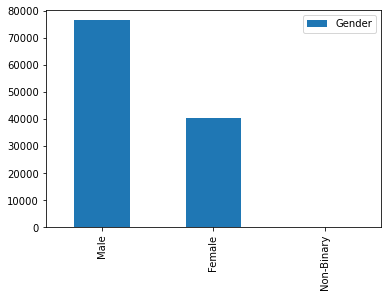

In [33]:
# Plot a bar plot for gender counts

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C354C641C0>],
      dtype=object)

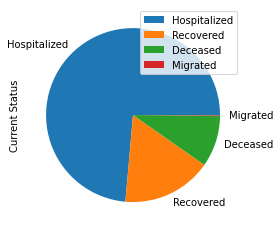

In [34]:
# Individual Current Status
# Plot a pie chart for the current status

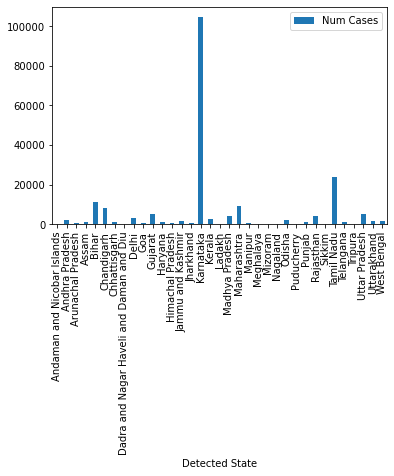

In [35]:
# Group the data by state and find the individual counts for each state
# Plot a bar chart for cases for each state

In [36]:
# Top 5 states reporting individual records

,Num Cases
Detected State,
Karnataka,104551.0
Tamil Nadu,23933.0
Bihar,11010.0
Maharashtra,9298.0
Chandigarh,8244.0


## Complete Data

We just worked on individual data but this does not provide us the clear picture lets work on complete data.

### Extact Count per Date

In [37]:
import datetime

In [38]:
# Group the data by date announced

In [39]:
# Let's check for a date e.g. 2020-09-20 0:00:00

Based on data dictionary:

- If the value is == 1 : The row indicates an individual record (age and gender info are subject to state bulletin releases).
- If the value != 1 (greater than or less than 1) : The row indicates a district level record.
- If the value > 0 and (detecteddistrict == '' or detecteddistrict == 'Unknown') : The row added without district details as state bulletin did not have district details at the point of data entry.
- If the value < 0 and (detecteddistrict == '' or detecteddistrict == 'Unknown') : The row added to adjust a previously added bulk entry as stated above
- If the value < 0 and (detecteddistrict != '' and detecteddistrict != 'Unknown') : The row added due to state bulletins providing a reduced count for that district/day/category combination.
- If the value == 0 : Ingore the record. This would've been an entry made and ignored later due to clarifications from state bulletins.

In [40]:
# We created a test count function that would give us clear idea about the data
def getCounts_test(data):
    ind_count=len(data[data['Num Cases']==1])
    dist_lvl_cnt=data[(data['Num Cases']>0) & ((data['Detected District'].isna()) |
    (data['Detected District']=='Unassigned') | (data['Detected District']=='Unknown')
                                              )]['Num Cases'].sum()
    neg_cnt=data[(data['Num Cases']<0) & ((data['Detected District'].isna()) |
    (data['Detected District']=='Unassigned') | (data['Detected District']=='Unknown')
    )]['Num Cases'].sum()
    empty=len(data[data['Num Cases']==0])
    return ind_count,dist_lvl_cnt,neg_cnt,empty

In [41]:
# Find the gcounts for the group

(180, 13444.0, 0.0, 0)

In [42]:
# Find the total number of cases for that day

181480.0

In [43]:
jh[(jh['Num Cases']<0) & ((jh['Detected District'].isna()) | 
    (jh['Detected District']=='Unassigned') | (jh['Detected District']=='Unknown'))]

,Patient Number,State Patient Number,Date Announced,Age Bracket,Gender,Detected City,Detected District,Detected State,State code,Current Status,Notes,Status Change Date,Source_1,Num Cases,Entry_ID


In [44]:
# Calculate the counts for that day for different statuses Deceased, Hospitalized, Migrated_Other, Recovered

,Num Cases
Current Status,
Deceased,1135.0
Hospitalized,87395.0
Migrated_Other,24.0
Recovered,92926.0


In [46]:
# Print the deceased numbers

1135.0

Thus, we have single day count.

### Per Day Count

In [47]:
# Create  a dataframe which has details: Date	Deceased	Migrated_Other	Hospitalized	Recovered for each day

In [48]:
# Let's check the data for last 10 days

,Date,Deceased,Migrated_Other,Hospitalized,Recovered
206,21/09/2020,1056.0,15.0,74493.0,102075.0
207,22/09/2020,1085.0,10.0,83362.0,89657.0
208,23/09/2020,1123.0,11.0,86703.0,87459.0
209,24/09/2020,1144.0,5.0,85921.0,81142.0
210,25/09/2020,1093.0,9.0,85717.0,93327.0
211,26/09/2020,1124.0,15.0,88759.0,92359.0
212,27/09/2020,1040.0,10.0,82770.0,74691.0
213,28/09/2020,775.0,6.0,69668.0,85194.0
214,29/09/2020,1178.0,20.0,80500.0,86150.0
215,30/09/2020,95.0,0.0,10181.0,8194.0


In [49]:
# Read the original data
orig=pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv')

In [138]:
# Get the latest 5 details

,Date,Deceased,Migrated_Other,Hospitalized,Recovered
74,12/05/2020,120.0,0.0,3562.0,1905.0
105,12/06/2020,388.0,0.0,11306.0,7263.0
135,12/07/2020,497.0,0.0,29106.0,18198.0
166,12/08/2020,950.0,3.0,67066.0,57759.0
197,12/09/2020,1111.0,20.0,94414.0,77862.0


In [51]:
#  Compare with the out

,Date,Date_YMD,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
315,10 December,2020-12-10,29411,9796989,37707,9290133,411,141631
316,11 December,2020-12-11,29961,9826950,33492,9323625,442,142073
317,12 December,2020-12-12,30354,9857304,33087,9356712,391,142464
318,13 December,2020-12-13,27336,9884640,30640,9387352,338,142802
319,14 December,2020-12-14,21941,9906581,34421,9421773,354,143156


In [53]:
# Checking total counts:

Deceased:  96693.0
Migrated_Other:  880.0
Hospitalized:  6223292.0
Recovered:  5178418.0


In [92]:
# Resample the data by week

In [94]:
# Weekly counts of data

,Deceased,Migrated_Other,Hospitalized,Recovered
Date,,,,
2020-02-02,0.0,0.0,0.0,2.0
2020-02-09,0.0,0.0,0.0,1.0
2020-02-16,0.0,0.0,0.0,0.0
2020-02-23,0.0,0.0,0.0,0.0
2020-03-01,0.0,0.0,0.0,0.0
2020-03-08,0.0,0.0,8.0,28.0
2020-03-15,3.0,3.0,45.0,25.0
2020-03-22,6.0,0.0,247.0,37.0
2020-03-29,12.0,0.0,647.0,77.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C322830070>,
      dtype=object)

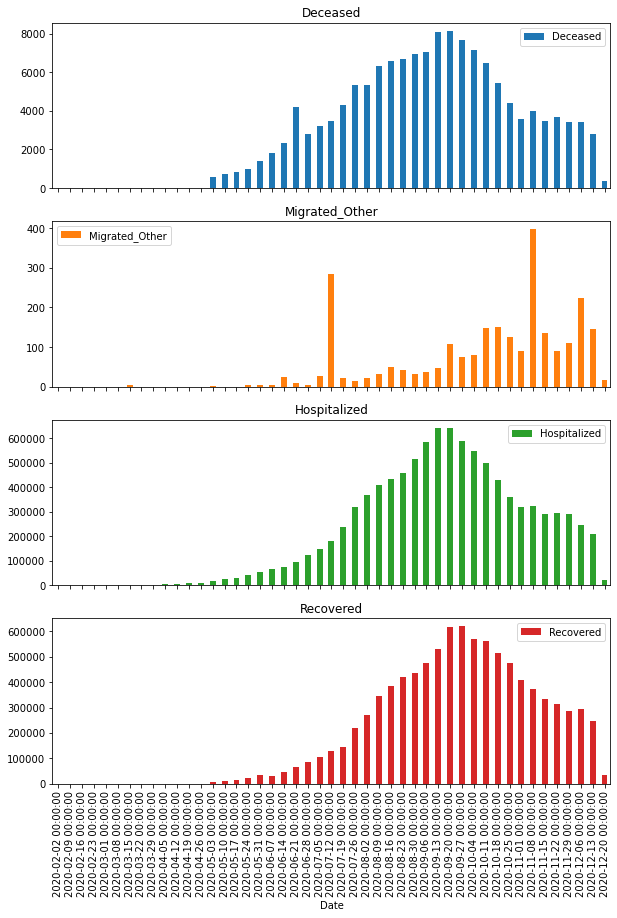

In [262]:
# Plot weekly rise

In [95]:
# Get Monthly Rise

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C360334190>,
      dtype=object)

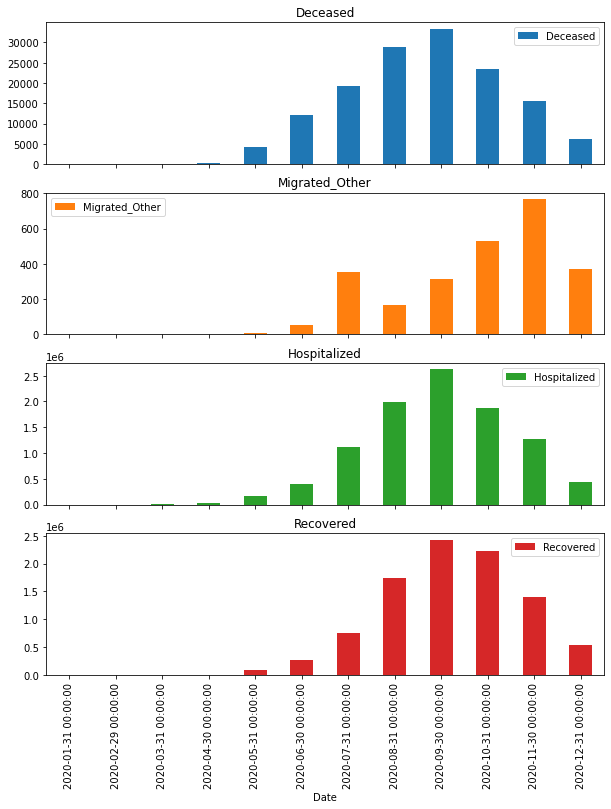

In [256]:
# Plot the monthly data

### Uses of this data:

- Data can be used for daily, weekly and monthly forecasting of data.
- Data can be used for visualization as well statewise and districtwise rise daily.
- Forecasting can be done at country level and state level as well.